<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/밑시딥2/DLFromScratch2

/content/drive/MyDrive/밑시딥2/DLFromScratch2


# LSTM 계층 구현하기

In [4]:
# 게이트가 추가된 RNN -> LSTM
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    #slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i , f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next): # 역전파 좀 복잡쓰;;
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    tanh_c_next = np.tanh(c_next)
    
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    
    dc_prev = ds * f
    
    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i
    
    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)
    
    dA = np.hstack((df, dg, di, do))
    
    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)
    
    return dx, dh_prev, dc_prev

# Time LSTM 계층 구현하기

In [5]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful
      
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

# Rnnlm 모델

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

# 보면, 여기서 구현을 안 다룬 계층들이 존재하지만, 다 개념은 같기에 안 다루고 import 해서 사용..
class Rnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
      TimeEmbedding(embed_W),
      TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
      TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
        xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

# 모델 학습시켜주기

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.11
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 2856.40
| 에폭 1 |  반복 41 / 1327 | 시간 14[s] | 퍼플렉서티 1250.29
| 에폭 1 |  반복 61 / 1327 | 시간 21[s] | 퍼플렉서티 953.09
| 에폭 1 |  반복 81 / 1327 | 시간 27[s] | 퍼플렉서티 819.30
| 에폭 1 |  반복 101 / 1327 | 시간 34[s] | 퍼플렉서티 654.19
| 에폭 1 |  반복 121 / 1327 | 시간 41[s] | 퍼플렉서티 654.02
| 에폭 1 |  반복 141 / 1327 | 시간 48[s] | 퍼플렉서티 606.81
| 에폭 1 |  반복 161 / 1327 | 시간 54[s] | 퍼플렉서티 576.05
| 에폭 1 |  반복 181 / 1327 | 시간 61[s] | 퍼플렉서티 593.53
| 에폭 1 |  반복 201 / 1327 | 시간 68[s] | 퍼플렉서티 511.01
| 에폭 1 |  반복 221 / 1327 | 시간 74[s] | 퍼플렉서티 496.03
| 에폭 1 |  반복 241 / 1327 | 시간 81[s] | 퍼플렉서티 444.26
| 에폭 1 |  반복 261 / 1327 | 시간 88[s] | 퍼플렉서티 468.93
| 에폭 1 |  반복 281 / 1327 | 시간 94[s] | 퍼플렉서티 455.43
| 에폭 1 |  반복 301 / 1327 | 시간 101[s] | 퍼플렉서티 391.98
| 에폭 1 |  반복 321 / 1327 | 시간 107[s] | 퍼플렉서티 340.96
| 에폭 1 |  반복 341 / 1327 | 시간 114[s] | 퍼플렉서티 399.05
| 에폭 1 |  반복 361 / 1327 | 시간 121[s] | 퍼플렉서티 408.25
| 에폭 1 |  반복 381 / 1327 | 시간 127[s] | 퍼플렉서티 335.51

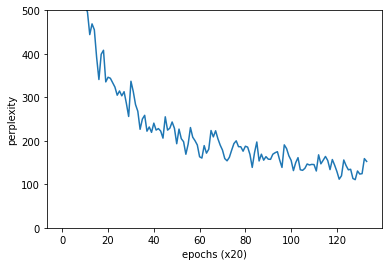

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  158.0022111756785


In [7]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from Chap06_Fancy_RNN.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 2      # 원래 4번 수행이 적혀있었으나, 2번으로 단축시킴
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()